## Root Mean Squared Error (RMSE) analysis
To validate the unmixing model, simulated spectra were generated and compared to unmixed spectra using RMSE. The formula for simulated spectra generation is as follows:

**Simulated spectrum = (1 - % soil) * average leaf endmember + % soil * average soil endmember**

Two RMSE analyses are conducted. In this workbook, unmixing is performed using the entire endmember library and all the nadir measurements. RMSE is calculated at soil fractions of 5%, 25%, 50%, 75% and 95%. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Functions
# calculating RMSE
def nan_rmse(a, b):
    """Compute RMSE and ignoring NaNs."""
    a = np.asarray(a, dtype=np.float64)
    b = np.asarray(b, dtype=np.float64)
    diff = a - b
    mask = ~np.isnan(diff)
    if not np.any(mask):
        return np.nan
    return np.sqrt(np.mean(diff[mask] ** 2))

# loading the spectra
def load_spectra_csv(path):
    """Load CSV spectra: first column = pixel names, rest = reflectances"""
    df = pd.read_csv(path)
    pixel_names = df.iloc[:, 0].values
    spectra = df.iloc[:, 1:].astype(float).values
    wavelengths = df.columns[1:].astype(float)
    return pixel_names, spectra, wavelengths

# formula to get simulated spectra
def simulate_mixture(leaf, soil, soil_frac):
    """Linear mixing simulation"""
    return (1.0 - soil_frac) * leaf + soil_frac * soil

# setting the range (low to high aka upper and lower bounds) for selecting spectra in each class
def class_indices(soil_frac, low, high):
    return np.where((soil_frac >= low) & (soil_frac <= high))[0]

In [3]:
# load in files
# Mixed spectra
pixel_names, mixed_spectra, wavelengths = load_spectra_csv(r"C:\Users\zhalem\Downloads\SpectralUnmixing.jl-v0.2.7\emit-sds-SpectralUnmixing.jl-3e47809\examples\mixed_rows_test.csv")

# Soil fractions
soil_frac = pd.read_csv(r"C:\Users\zhalem\Downloads\SpectralUnmixing.jl-v0.2.7\emit-sds-SpectralUnmixing.jl-3e47809\examples\soil_fractionz.csv").iloc[:, 1].astype(float).values

# Average soil endmember
soil_endmember_df = pd.read_csv(r"C:\Users\zhalem\Downloads\SpectralUnmixing.jl-v0.2.7\emit-sds-SpectralUnmixing.jl-3e47809\examples\average_soil_endmember.csv")
average_soil_endmember = soil_endmember_df.iloc[0, 1:].values

# Average leaf endmember
leaf_end_df = pd.read_csv(r"C:\Users\zhalem\Downloads\SpectralUnmixing.jl-v0.2.7\emit-sds-SpectralUnmixing.jl-3e47809\examples\leaf_endmember_average.csv")
average_leaf_endmember = leaf_end_df.iloc[0, 1:].values

# Unmixed (pure leaf) spectra from Julia
_, unmixed_spectra, unmixed_wavelengths = load_spectra_csv(r"C:\Users\zhalem\Documents\ASD_data\PANGEOS_NO_2025\csv_exports\pureleaf_unmixed.csv")

In [4]:
# selecting spectra by ±5% buffer (e.g. spectra with soil fractions between 0-10% were averaged for the 5% class) to capture broader spectral variability
soil_classes = {
    0.05: (0.00, 0.10),
    0.25: (0.20, 0.30),
    0.50: (0.45, 0.55),
    0.75: (0.70, 0.80),
    0.95: (0.90, 1.00),}

# Containers
avg_measured_list = []
sim_list = []
rmse_list = []
soil_fracs = []
results = []

In [5]:
# Compute RMSEs per soil fraction class
for target, (low, high) in soil_classes.items():
    idx = class_indices(soil_frac, low, high)
    n = len(idx)
    if n == 0:
        print(f"Soil {target:.2f}: no spectra in bin")
        continue

    mean_mixed = np.nanmean(mixed_spectra[idx], axis=0)
    mean_unmixed = np.nanmean(unmixed_spectra[idx], axis=0)
    simulated = simulate_mixture(average_leaf_endmember, average_soil_endmember, target)

    rmse_mixed_unmixed = nan_rmse(mean_mixed, mean_unmixed)
    rmse_meas_vs_sim = nan_rmse(mean_mixed, simulated)

    results.append({
        "soil_target": target,
        "soil_range": f"{low:.2f}–{high:.2f}",
        "N_spectra": n,
        "RMSE_mixed_vs_unmixed": rmse_mixed_unmixed,
        "RMSE_measured_vs_simulated": rmse_meas_vs_sim})

    avg_measured_list.append(mean_mixed)
    sim_list.append(simulated)
    rmse_list.append(rmse_meas_vs_sim)
    soil_fracs.append(target)

    print(
        f"Soil {target:.2f} ({low:.2f}–{high:.2f}), N={n}, "
        f"RMSE mixed–unmixed = {rmse_mixed_unmixed:.6f}, "
        f"RMSE mixed–sim = {rmse_meas_vs_sim:.6f}")

results_df = pd.DataFrame(results)

Soil 0.05 (0.00–0.10), N=128, RMSE mixed–unmixed = 0.000716, RMSE mixed–sim = 0.076724
Soil 0.25 (0.20–0.30), N=48, RMSE mixed–unmixed = 0.020380, RMSE mixed–sim = 0.044038
Soil 0.50 (0.45–0.55), N=30, RMSE mixed–unmixed = 0.046161, RMSE mixed–sim = 0.014587
Soil 0.75 (0.70–0.80), N=7, RMSE mixed–unmixed = 0.112028, RMSE mixed–sim = 0.027998
Soil 0.95 (0.90–1.00), N=6, RMSE mixed–unmixed = 1.933163, RMSE mixed–sim = 0.122507


C:\Users\zhalem\AppData\Local\Temp\ipykernel_9476\2695668578.py:10: RuntimeWarning: Mean of empty slice
  mean_mixed = np.nanmean(mixed_spectra[idx], axis=0)
C:\Users\zhalem\AppData\Local\Temp\ipykernel_9476\2695668578.py:11: RuntimeWarning: Mean of empty slice
  mean_unmixed = np.nanmean(unmixed_spectra[idx], axis=0)


C:\Users\zhalem\AppData\Local\Temp\ipykernel_9476\4175050354.py:14: RuntimeWarning: Mean of empty slice
  mean_mixed = np.nanmean(mixed_spectra[idx], axis=0)
C:\Users\zhalem\AppData\Local\Temp\ipykernel_9476\4175050354.py:15: RuntimeWarning: Mean of empty slice
  mean_unmixed = np.nanmean(unmixed_spectra[idx], axis=0)


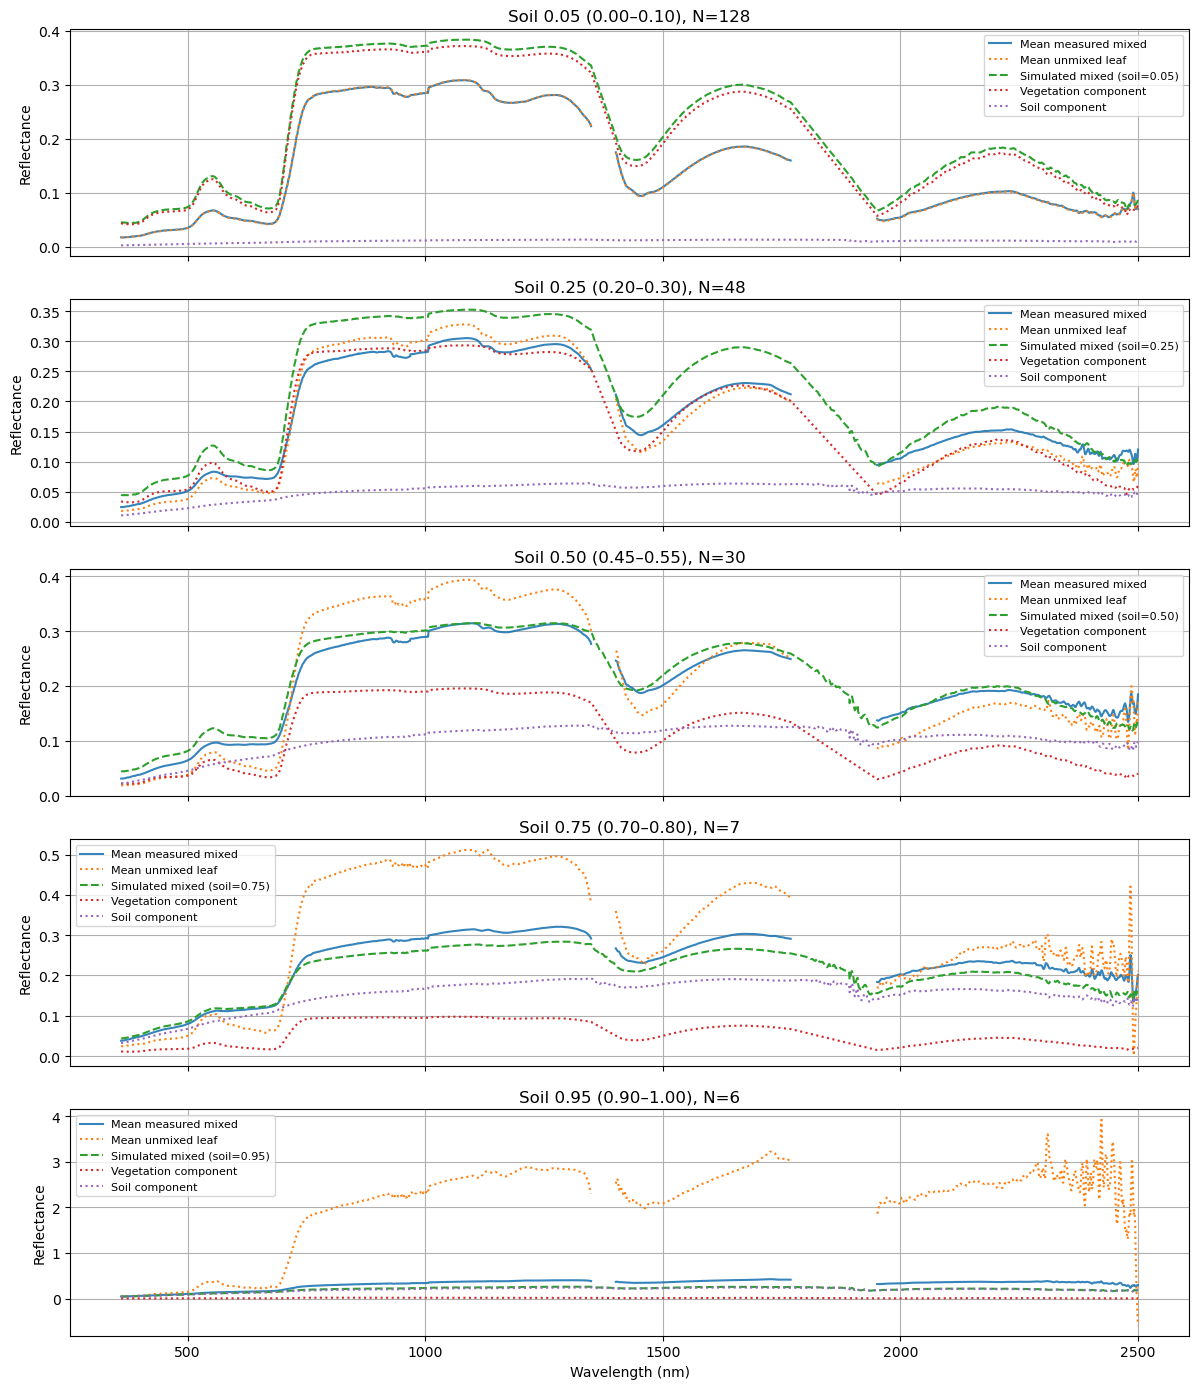

In [6]:
# Plot all spectra
fig, axes = plt.subplots(len(soil_classes), 1, figsize=(12, 14), sharex=True)

for ax, (target, (low, high)) in zip(axes, soil_classes.items()):

    idx = class_indices(soil_frac, low, high)
    n = len(idx)
    if n == 0:
        ax.set_title(f"Soil {target:.2f} (no data)")
        continue

    # Class means
    mean_mixed = np.nanmean(mixed_spectra[idx], axis=0) # select all pixels in specific soil fraction class and get average --> mean mixed spectrum
    mean_unmixed = np.nanmean(unmixed_spectra[idx], axis=0) # same as mean_mixed but for unmixed
    simulated = simulate_mixture(average_leaf_endmember, average_soil_endmember, target) # call simulation formula to get simulated spectrum

    # Components for visualization
    veg_component = (1 - target) * average_leaf_endmember
    soil_component = target * average_soil_endmember

    # --- Plot ---
    ax.plot(wavelengths, mean_mixed, label="Mean measured mixed", alpha=0.9)
    ax.plot(wavelengths, mean_unmixed, label="Mean unmixed leaf", linestyle=":")
    ax.plot(wavelengths, simulated, label=f"Simulated mixed (soil={target:.2f})", linestyle="--")
    ax.plot(wavelengths, veg_component, label="Vegetation component", linestyle=":")
    ax.plot(wavelengths, soil_component, label="Soil component", linestyle=":")

    ax.set_title(f"Soil {target:.2f} ({low:.2f}–{high:.2f}), N={n}")
    ax.set_ylabel("Reflectance")
    ax.grid(True)
    ax.legend(fontsize=8)

axes[-1].set_xlabel("Wavelength (nm)")
plt.tight_layout()
plt.show()

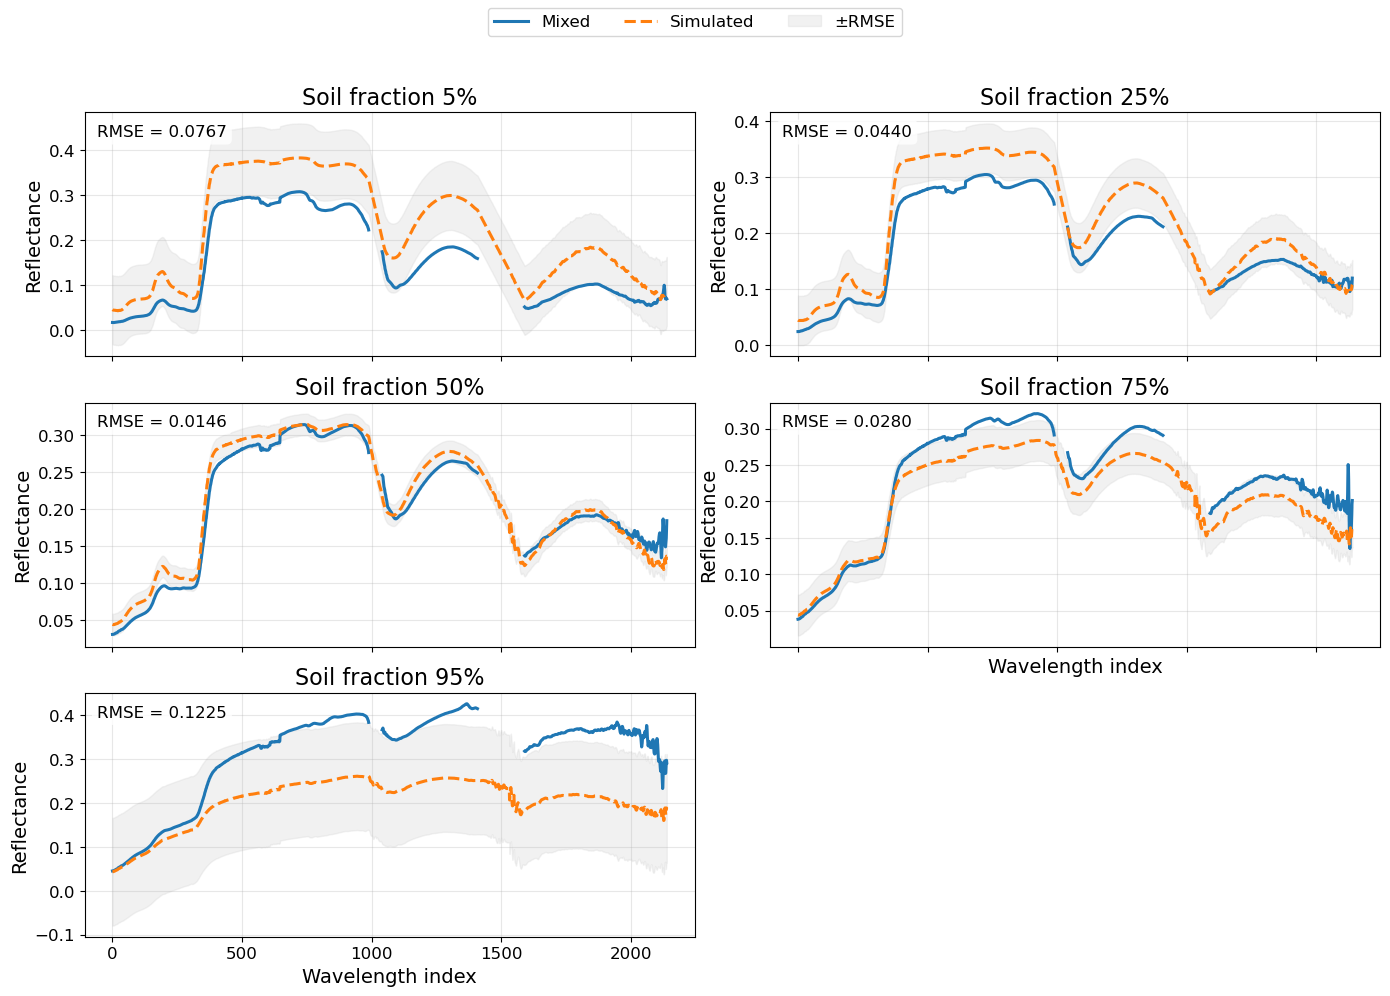

In [8]:
# plot specifically rmse range with simulated versus mixed
fig, axes = plt.subplots(3, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()
fig.delaxes(axes[-1])  # remove extra subplot
axes = axes[:len(avg_measured_list)]

line_w = 2.2
title_font = 16
label_font = 14
tick_font = 12
legend_font = 12

for i, ax in enumerate(axes):
    measured = np.asarray(avg_measured_list[i], dtype=np.float64)
    simulated = np.asarray(sim_list[i], dtype=np.float64)
    rmse = float(rmse_list[i])

    L = min(len(measured), len(simulated))
    measured = measured[:L]
    simulated = simulated[:L]

    ax.plot(measured, label="Mixed", linewidth=line_w)
    ax.plot(simulated, '--', label="Simulated", linewidth=line_w)
    ax.fill_between(np.arange(L),
                    simulated - rmse,
                    simulated + rmse,
                    color='lightgray', alpha=0.3, label="±RMSE")
    # where the error bars are shaded around the simulated spectrum to show how far the mixed spectrum deviates from the simulated
    
    ax.set_title(f"Soil fraction {soil_fracs[i]*100:.0f}%", fontsize=title_font)
    ax.set_ylabel("Reflectance", fontsize=label_font)
    ax.tick_params(axis='both', labelsize=tick_font)
    ax.grid(True, alpha=0.3)

    ax.text(0.02, 0.95,
            f"RMSE = {rmse:.4f}",
            transform=ax.transAxes,
            fontsize=legend_font,
            verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8, edgecolor="none"))

for ax in axes[-2:]:
    ax.set_xlabel("Wavelength index", fontsize=label_font)

handles, labels_leg = axes[0].get_legend_handles_labels()
fig.legend(handles, labels_leg, loc='upper center', ncol=3, fontsize=legend_font, frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()